# Создание нейронной сети для распознавания растений на изображениях.

## Описание датасета

Датасет включает в себя разнообразную коллекцию из 20 классов растений 8 типов, включая цветы, сельскохозяйственные, фруктовые, технические, лекарственные, ореховые, клубнеплодные и овощные растения. Весь датасет разбит на 3 категории - обучаемая, проверочная и тестовая. Каждый файл в отдельной папке относится к одному классу растений. Этот датасет будет использован для обучения и оценки модели классификации изображений.

### Обзор данных
Давайте определим такие характеристики изображений датасета, как:

- Средний размер
- Среднее число каналов
- Количество изображений по классам и категориям
- Общее количество изображений

#### Импортируем нужные библиотеки

In [1]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns

from PIL import Image
from matplotlib.image import imread
from matplotlib import pyplot as plt

### Проведем анализ датасета

- Превью классов растений

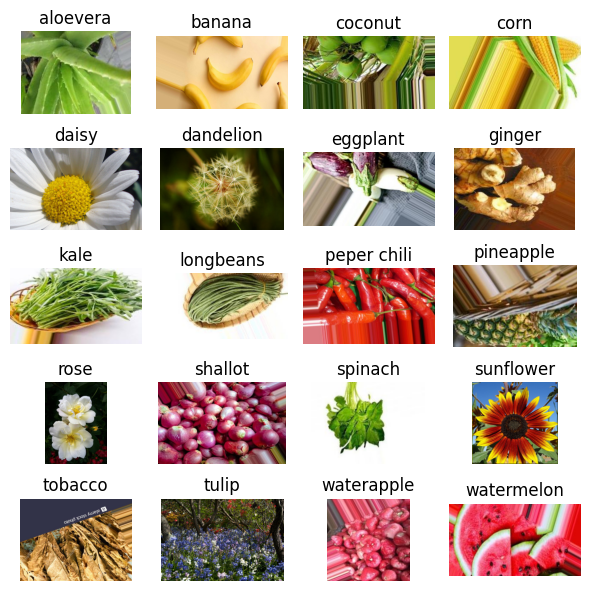

In [2]:
path = 'dataset/train'

os.listdir(path)

fig = plt.figure(figsize=(6,6)) 
rows = 5
columns = 4

for i, image_filename in enumerate(os.listdir(path)):

    first_img_path = os.listdir(os.path.join(path, image_filename))[0]
    first_image = imread(os.path.join(path, image_filename, first_img_path))
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(first_image)
    plt.title('{}'.format(image_filename, fontsize=10))

plt.tight_layout()
plt.show()

- Средние размерности изображений.

In [3]:
dim1 = []    # ширина
dim2 = []    # высота
channels = []  # каналы

for i, image_filename in enumerate(os.listdir(path)):
    
    subfolders_path = os.path.join(path, image_filename)
    for image_path in os.listdir(subfolders_path):
        image = imread(os.path.join(subfolders_path,image_path))

        # на случай одноканальных изображений
        if len(image.shape) < 3:
            image = image.reshape(image.shape + (1,))
            
        d1,d2,color = image.shape
        dim1.append(d1)
        dim2.append(d2)
        channels.append(color)

- Отобразим результат на графике:

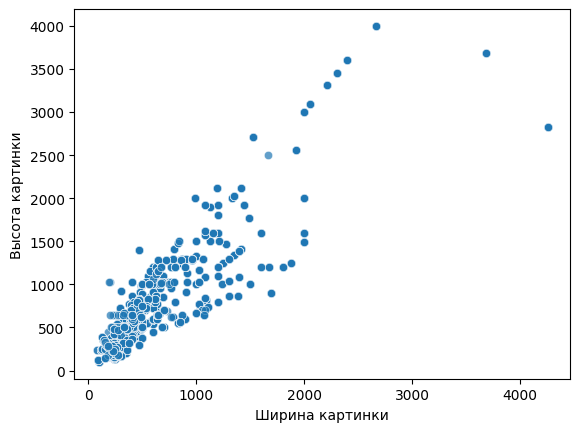

In [4]:
sns.scatterplot(x=dim1, y=dim2, alpha = 0.7)
plt.xlabel('Ширина картинки')
plt.ylabel('Высота картинки');

Как видно из графика:
- Ширина картинок достигает 3500+ пикселей.
- Высота картинок достигает 3500+ пикселей.

Однако в большинстве ширина и высота изображений не превышает 1000 пикселей.

In [5]:
# средняя ширина
mean_width = int(np.mean(dim1))
print(mean_width)
# средняя высота
mean_height = int(np.mean(dim2))
print(mean_height)
# кол-во найденных каналов
print(np.unique(channels))

341
445
[3]


Кол-во найденных каналов изображений датасета - [3], а это значит, что пиксели всех изображений представлены в виде R, G и B (Red, Green, Blue). 
При обучении CNN важно, чтобы входные изображения имели одинаковый размер, поэтому мы будем изменять его до (64, 64, 3), так как при таком масштабировании не потеряются детали для распознавания, но повысится производительность модели.

In [6]:
input_shape =  (64, 64, 3)

- Посчитаем количество изображений для того, чтобы убедиться в наполненности и равномерности распределения изображений по классам и категориям в датасете:

In [7]:
train_data_sum = 0
val_data_sum = 0
test_data_sum = 0
images_count_dict = {"train": {},
                     "val": {},
                     "test": {}}

for train_fp, val_fp, test_fp in zip(os.listdir('dataset/train'),
                                     os.listdir('dataset/validation'),
                                     os.listdir('dataset/test')):
    train_images_count = len(os.listdir(os.path.join('dataset/train', train_fp)))
    val_images_count = len(os.listdir(os.path.join('dataset/validation', val_fp)))
    test_images_count = len(os.listdir(os.path.join('dataset/test', test_fp)))

    images_count_dict["train"][train_fp] = train_images_count
    images_count_dict["val"][val_fp] = val_images_count
    images_count_dict["test"][test_fp] = test_images_count
    train_data_sum += train_images_count
    val_data_sum += val_images_count
    test_data_sum += test_images_count
    print(f"{train_fp} | Train: {train_images_count} | Validation: {val_images_count} | Test: {test_images_count}")

print(f"Всего: {train_data_sum} обучающих картинок")
print(f"Всего: {val_data_sum} проверочных картинок")
print(f"Всего: {test_data_sum} тестовых картинок")

aloevera | Train: 599 | Validation: 101 | Test: 100
banana | Train: 599 | Validation: 101 | Test: 100
coconut | Train: 599 | Validation: 101 | Test: 100
corn | Train: 599 | Validation: 101 | Test: 100
daisy | Train: 564 | Validation: 100 | Test: 100
dandelion | Train: 600 | Validation: 100 | Test: 100
eggplant | Train: 599 | Validation: 101 | Test: 100
ginger | Train: 599 | Validation: 101 | Test: 100
kale | Train: 599 | Validation: 101 | Test: 100
longbeans | Train: 599 | Validation: 101 | Test: 100
peper chili | Train: 599 | Validation: 101 | Test: 100
pineapple | Train: 599 | Validation: 101 | Test: 100
rose | Train: 584 | Validation: 100 | Test: 100
shallot | Train: 599 | Validation: 101 | Test: 100
spinach | Train: 599 | Validation: 101 | Test: 100
sunflower | Train: 533 | Validation: 100 | Test: 100
tobacco | Train: 599 | Validation: 101 | Test: 100
tulip | Train: 600 | Validation: 100 | Test: 100
waterapple | Train: 599 | Validation: 101 | Test: 100
watermelon | Train: 599 | Val

- Отобразим результат на графике:

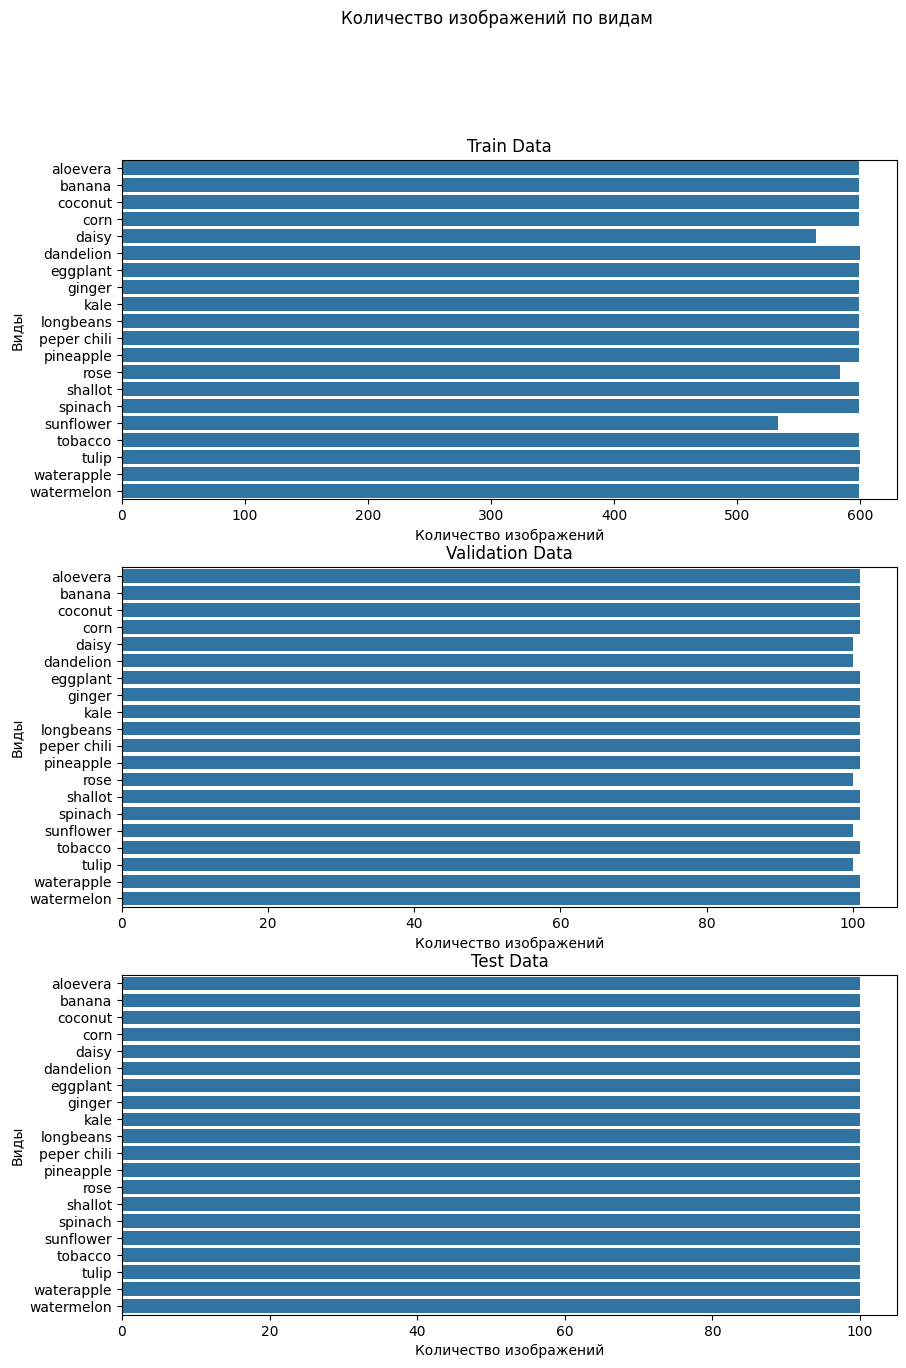

In [8]:
train_data = list(images_count_dict["train"].items())
val_data = list(images_count_dict["val"].items())
test_data = list(images_count_dict["test"].items())
num_classes = len(train_data)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.barplot(ax=axes[0], y=[x[0] for x in train_data], x=[x[1] for x in train_data])
axes[0].set_title('Train Data')
axes[0].set_xlabel('Количество изображений')
axes[0].set_ylabel('Виды')

sns.barplot(ax=axes[1], y=[x[0] for x in val_data], x=[x[1] for x in val_data])
axes[1].set_title('Validation Data')
axes[1].set_xlabel('Количество изображений')
axes[1].set_ylabel('Виды')

sns.barplot(ax=axes[2], y=[x[0] for x in test_data], x=[x[1] for x in test_data])
axes[2].set_title('Test Data')
axes[2].set_xlabel('Количество изображений')
axes[2].set_ylabel('Виды')

fig.suptitle('Количество изображений по видам')
plt.show()

После того, как были определены средние размеры изображений, количество каналов и наполненность датасета, можно приступать к проектированию архитектуры нейросети.

## Нейронная сеть

- Выбираем архитектуру
    - Сверточный модуль:
        - Сверточный слой, выделяющий 32 признака по фильтрам размерами 3 и глубиной 3 (RGB каналы изображений для разделения цветов) с функцией активации `ReLU`
        - Слой макс-пуллинга, сжимающий карты первичных признаков в 2 раза
        - Сверточный слой, выделяющий 64 признака по фильтрам размерами 3 и глубиной 3 с активацией `ReLU`
        - Слой макс-пуллинга, сжимающий карты вторичных признаков в 2 раза
        - Сверточный слой, выделяющий 128 признака по фильтрам размерами 3 и глубиной 3 с активацией `ReLU`
        - Слой макс-пуллинга, сжимающий карты вторичных признаков в 2 раза
        - Преобразование карт признаков в одномерный массив
    - Полносвязный модуль:
        - Скрытый полносвязный слой из 512 нейронов с функцией активации ReLU со значением Dropout 0.5
        - Скрытый полносвязный слой из 64 нейронов с функцией активации ReLU со значением Dropout 0.5
        - Выходной полносвязный слой из 15 нейронов (количество классов) с функцией активации `softmax` со значением Dropout 0.5

- Составляем модель нейронной сети по описанной выше архитектуре:

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Rescaling(1 / 255.0),

    # 1 блок
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 2 блок
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3 блок
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 4 блок
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # классификатор
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

- Компилируем модель с оптимизатором `Adam` и рассчетой потерь по `категориальной кросс-энтропии`:

In [10]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

- Сделаем summary модели для оценки ее сложности:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                        

- Загрузим изображения в виде датафреймов из папки 'dataset':

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    seed=123,
    image_size=(64, 64),
    batch_size=32)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/validation",
    seed=456,
    image_size=(64, 64),
    batch_size=32)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    seed=789,
    image_size=(64, 64),
    batch_size=32)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 11866 files belonging to 20 classes.
Found 2015 files belonging to 20 classes.
Found 2000 files belonging to 20 classes.


Обучим нашу нейросеть с 50 эпохами с колбэками для предотвращения переобучения в виде уменьшения коэффициента обучения на плато до 0.00001:

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/50
371/371 [==============================] - 7s 13ms/step - loss: 4.1341 - accuracy: 0.1199 - val_loss: 3.2530 - val_accuracy: 0.1752 - lr: 0.0010
Epoch 2/50
371/371 [==============================] - 3s 9ms/step - loss: 2.8784 - accuracy: 0.1895 - val_loss: 2.4564 - val_accuracy: 0.3042 - lr: 0.0010
Epoch 3/50
371/371 [==============================] - 3s 9ms/step - loss: 2.5137 - accuracy: 0.2162 - val_loss: 2.2732 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 4/50
371/371 [==============================] - 3s 9ms/step - loss: 2.3227 - accuracy: 0.2449 - val_loss: 2.0729 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 5/50
371/371 [==============================] - 4s 9ms/step - loss: 2.2085 - accuracy: 0.2692 - val_loss: 2.4068 - val_accuracy: 0.3132 - lr: 0.0010
Epoch 6/50
371/371 [==============================] - 3s 9ms/step - loss: 2.0723 - accuracy: 0.3095 - val_loss: 1.8458 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 7/50
371/371 [==============================] - 3s 9ms/step - l

- Построим графики потерь и точности по мере обучения:

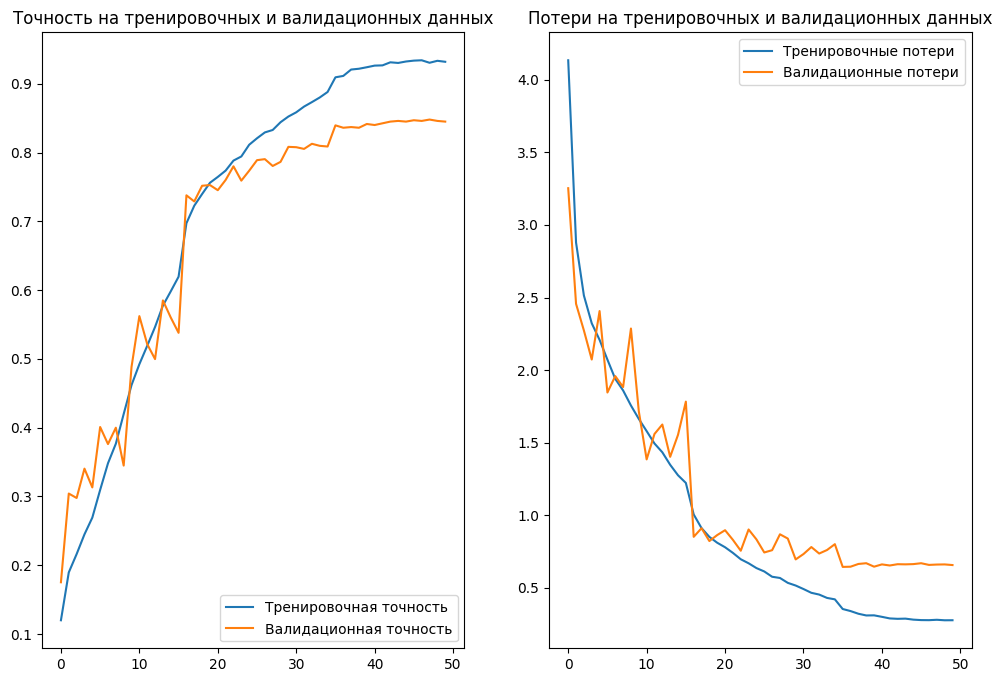

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Тренировочная точность')
plt.plot(epochs_range, val_acc, label='Валидационная точность')
plt.legend(loc='lower right')
plt.title('Точность на тренировочных и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Тренировочные потери')
plt.plot(epochs_range, val_loss, label='Валидационные потери')
plt.legend(loc='upper right')
plt.title('Потери на тренировочных и валидационных данных')

plt.show()

- Сохраним веса модели для дальнейшего использования:

In [15]:
model.save('plants.h5')

- Загрузим нашу модель и проведем тесты:

In [19]:
model_loaded = tf.keras.models.load_model('plants.h5')
src_classes = os.listdir("dataset/train")

_, test_accuracy = model_loaded.evaluate(test_ds)

print(f"Тестовая точность: {test_accuracy:.4f}")

63/63 [==============================] - 1s 6ms/step - loss: 0.7075 - accuracy: 0.8515
Тестовая точность: 0.8515
